# Lab 5: Species Distribution Modeling with Bagging 

Due Date: Feb 20, 2025 
Jordan Sibley 

Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# Show all columns 
pd.set_option("display.max.columns", None)

# Read in data 
birds = pd.read_csv('BirdTraitData.csv', encoding = 'unicode_escape', na_values = '-999')
birds.head(2)

,Order,Family,Genus,Species,Authority,CommonName,AdultBodyMass,DietBreadth,Diet: invertebrates,Diet: vertebrates,Diet: fruits,Diet: flower/nectar/pollen/gums,Diet: seeds,Diet: other plant materials,Diet: scavenge; garbage; carrion; offal; carcasses,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Dry,Humid,Montane,Subarid,Subhumid,Alaotra.Mangoro,Amoron.i.Mania,Analamanga,Analanjirofo,Androy,Anosy,Atsimo.Andrefana,Atsimo.Atsinanana,Atsinanana,Betsiboka,Boeny,Bongolava,DIANA,Haute.Matsiatra,Ihorombe,Itasy,Melaky,Menabe,SAVA,Sofia,Vakinankaratra,Vatovavy.Fitovinany,Antananarivo,Antsiranana,Fianarantsoa,Mahajanga,Toamasina,Toliara,References
0,Accipitriformes,Accipitridae,Accipiter,Accipiter francesiae,"Smith, 1834",Frances's Sparrowhawk,138.5,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,31.0,3.0,3.85,NaN,NaN,arboreal,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,109; 254; 168; 376; 368; 199
1,Accipitriformes,Accipitridae,Accipiter,Accipiter henstii,"(Schlegel, 1873)",Henst's Goshawk,1050.0,1.0,no,yes,no,no,no,no,no,3.0,2.0,3.0,no,39.5,2.5,58.50,46.95,NaN,arboreal,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,109; 254; 376; 200; 168


In [3]:
# Rename columns with colons to underscores 
birds.columns = birds.columns.str.replace(": ", "_")
birds.head(2)

,Order,Family,Genus,Species,Authority,CommonName,AdultBodyMass,DietBreadth,Diet_invertebrates,Diet_vertebrates,Diet_fruits,Diet_flower/nectar/pollen/gums,Diet_seeds,Diet_other plant materials,Diet_scavenge; garbage; carrion; offal; carcasses,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Dry,Humid,Montane,Subarid,Subhumid,Alaotra.Mangoro,Amoron.i.Mania,Analamanga,Analanjirofo,Androy,Anosy,Atsimo.Andrefana,Atsimo.Atsinanana,Atsinanana,Betsiboka,Boeny,Bongolava,DIANA,Haute.Matsiatra,Ihorombe,Itasy,Melaky,Menabe,SAVA,Sofia,Vakinankaratra,Vatovavy.Fitovinany,Antananarivo,Antsiranana,Fianarantsoa,Mahajanga,Toamasina,Toliara,References
0,Accipitriformes,Accipitridae,Accipiter,Accipiter francesiae,"Smith, 1834",Frances's Sparrowhawk,138.5,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,31.0,3.0,3.85,NaN,NaN,arboreal,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,109; 254; 168; 376; 368; 199
1,Accipitriformes,Accipitridae,Accipiter,Accipiter henstii,"(Schlegel, 1873)",Henst's Goshawk,1050.0,1.0,no,yes,no,no,no,no,no,3.0,2.0,3.0,no,39.5,2.5,58.50,46.95,NaN,arboreal,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,109; 254; 376; 200; 168


In [4]:
# Rename columns
birds_clean = birds.rename(columns ={'Diet_invertebrates':'Diet_Invertebrates',
                     'Diet_vertebrates':'Diet_Vertebrates',
                     'Diet_fruits':'Diet_Fruits',
                     'Diet_flower/nectar/pollen/gums':'Diet_Flowers',
                     'Diet_seeds':'Diet_Seeds',
                     'Diet_other plant materials':'Diet_Plants',
                     'Diet_scavenge; garbage; carrion; offal; carcasses':'Diet_Other'})

# Select columns with key variables
birds_clean = birds_clean[['AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates', 'Diet_Vertebrates','Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 'TrophicLevel','ActivityCycle', 'ForagingStratum', 'MigratoryStatus','IncubationTime', 'ClutchSize', 'EggLength', 'EggWidth','EggMass', 'NestingHabit','MaxLongevity', 'Subarid']]

# Display dataframe 
birds_clean.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,31.0,3.0,3.85,NaN,NaN,arboreal,NaN,1
1,1050.0,1.0,no,yes,no,no,no,no,no,3.0,2.0,3.0,no,39.5,2.5,58.50,46.95,NaN,arboreal,NaN,1
2,181.0,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,35.0,2.5,38.35,31.90,NaN,arboreal,NaN,1
3,292.0,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,31.0,1.5,43.70,35.20,29.1,arboreal,NaN,1
4,511.0,2.0,yes,yes,no,no,no,no,no,3.0,3.0,4.0,no,35.5,2.0,54.50,45.00,NaN,arboreal,144.0,1


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [5]:
cat_col = birds_clean.select_dtypes(include=['object'])

for column in cat_col:
    encoder = LabelEncoder()
    birds_clean[column] = encoder.fit_transform(birds_clean[column])


birds_clean.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,1,1,0,0,0,0,0,3.0,3.0,3.0,0,31.0,3.0,3.85,NaN,NaN,1,NaN,1
1,1050.0,1.0,0,1,0,0,0,0,0,3.0,2.0,3.0,0,39.5,2.5,58.50,46.95,NaN,1,NaN,1
2,181.0,2.0,1,1,0,0,0,0,0,3.0,3.0,3.0,0,35.0,2.5,38.35,31.90,NaN,1,NaN,1
3,292.0,2.0,1,1,0,0,0,0,0,3.0,3.0,3.0,0,31.0,1.5,43.70,35.20,29.1,1,NaN,1
4,511.0,2.0,1,1,0,0,0,0,0,3.0,3.0,4.0,0,35.5,2.0,54.50,45.00,NaN,1,144.0,1


### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [6]:
# Define features 
X = birds_clean.drop(['Subarid'], axis = 1)
y = birds_clean['Subarid']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

# Create bagging classifier 
bagging = BaggingClassifier(
            n_estimators = 100, # 100 trees in our bag 
            oob_score = True,
            bootstrap = True, 
            random_state=808)

# Train model 
bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [7]:
# Make predictions on the model 
bagging_preds = bagging.predict(X_test)

# Calculate the Out Of Bag Score 
oob_score = bagging.oob_score_

# Compute the accuracy 
print(f"Bagging Accuracy: {accuracy_score(y_test, bagging_preds):.3f}")
print(f"OOB Score: {oob_score:.3f}")

Bagging Accuracy: 0.945
OOB Score: 0.882


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

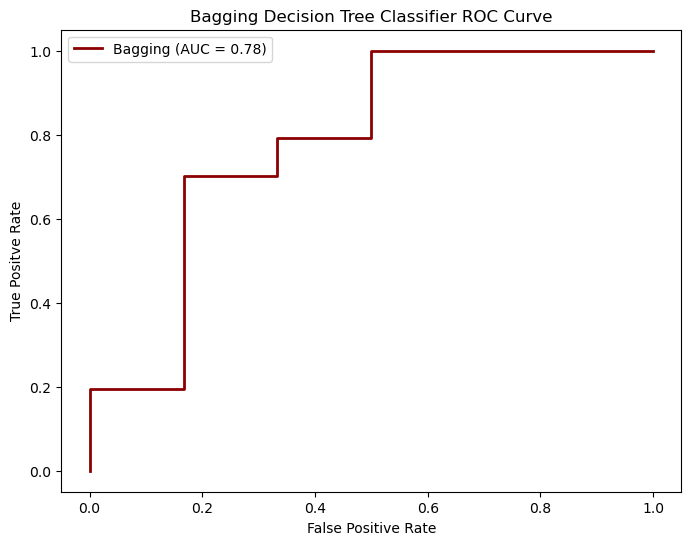

Subarid
1    217
0     25
Name: count, dtype: int64


In [8]:
# Calculate ROC curve 
fpr, tpr, _ = roc_curve(y_test, bagging.predict_proba(X_test)[:,1])

# Calculate AUC 
roc_auc_bagging = auc(fpr, tpr)

# Plot ROC curve 
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, color = 'darkred', lw = 2, label=f"Bagging (AUC = {roc_auc_bagging:.2f})")

# Labels 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.title('Bagging Decision Tree Classifier ROC Curve')

# Legend 
plt.legend()
plt.show()

# View majority and minorty class 
print(birds_clean['Subarid'].value_counts())

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

While the accuracy of the bagging model is quite high (score = 0.945), but the ROC curve reveals a area under the curve score of 0.78. This score is better than a random guess (0.5), however it does not indicate that the bagging model is a great fit for the data. This could be due to the class imbalance, which could make the accuracy score higher. 

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [9]:
# Separate majority (Subarid = 1) and minority classes (Subarid = 0)
X_majority_class = X_train[y_train == 1]
X_minority_class = X_train[y_train == 0]

y_majority_class = y_train[y_train==1]
y_minority_class = y_train[y_train==0]

# Upsample the minority class
X_minority_class_unsampled = resample(X_minority_class,
                               random_state = 808,
                               n_samples = len(X_majority_class))

y_minority_class_unsampled = resample(y_minority_class,
                               random_state = 808,
                               n_samples = len(y_majority_class))

# Combine majority and upsampled minority class
X_train_unsampled = pd.concat([X_minority_class_unsampled, X_majority_class])
y_train_unsampled = pd.concat([y_minority_class_unsampled, y_majority_class])

# Shuffle the dataset
X_train_unsampled = resample(X_train_unsampled, random_state=808)
y_train_unsampled = resample(y_train_unsampled, random_state=808)

# Print value counts 
print(f"Resampled data: \n {y_train_unsampled.value_counts()}")

Resampled data: 
 Subarid
1    159
0    141
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Bagging Accuracy: 0.822
OOB Score: 0.967


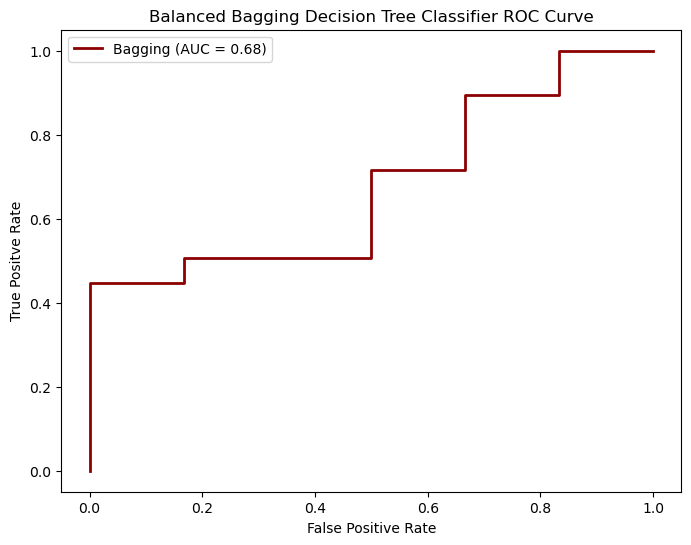

In [10]:
# Initialize bagging model 
bagging_balanced = BaggingClassifier(n_estimators = 100, 
                                     bootstrap = True, 
                                     oob_score = True, 
                                     random_state =808)

# Fit the model on unsampled data 
bagging_balanced.fit(X_train_unsampled, y_train_unsampled)

# Make predictions on the model 
bagging_balanced_preds = bagging_balanced.predict(X_test)

# Calculate the Out Of Bag Score 
oob_score_balanced = bagging_balanced.oob_score_

# Compute the accuracy 
print(f"Bagging Accuracy: {accuracy_score(y_test, bagging_balanced_preds):.3f}")
print(f"OOB Score: {oob_score_balanced:.3f}")


# Calculate ROC curve 
fpr_bal, tpr_bal, _ = roc_curve(y_test, bagging_balanced.predict_proba(X_test)[:,1])

# Calculate AUC 
roc_auc_bagging_balanced = auc(fpr_bal, tpr_bal)

# Plot ROC curve 
plt.figure(figsize = (8,6))
plt.plot(fpr_bal, tpr_bal, color = 'darkred', lw = 2, label=f"Bagging (AUC = {roc_auc_bagging_balanced:.2f})")

# Labels 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.title('Balanced Bagging Decision Tree Classifier ROC Curve')

# Legend 
plt.legend()
plt.show()


How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

This bagging model that was trained on the resampled balanced data has both a lower accuracy score and AUC than the orginial bagging model that was trained on the orginal unbalanced data. This suggests that training the model on the balanced data did not preform as well on unseen data, meaning the upscaling was not useful. 

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [11]:
# Calculate importance values 
importance = permutation_importance(bagging, 
                                    X_test, 
                                    y_test, 
                                    n_repeats = 10, 
                                    random_state = 808)
# List feature importance 
importance_df = pd.DataFrame(zip(X_test.columns, 
                                importance.importances_mean),
                            columns=['Feature', 'Importance'])

# Print the data frame sorted by feature importance
print(importance_df.sort_values(by = 'Importance', ascending = False))

               Feature  Importance
18        NestingHabit    0.026027
10       ActivityCycle    0.012329
0        AdultBodyMass    0.008219
19        MaxLongevity    0.006849
9         TrophicLevel    0.005479
16            EggWidth    0.004110
11     ForagingStratum    0.004110
15           EggLength    0.004110
7          Diet_Plants    0.002740
4          Diet_Fruits    0.002740
14          ClutchSize    0.001370
1          DietBreadth    0.000000
3     Diet_Vertebrates    0.000000
2   Diet_Invertebrates    0.000000
5         Diet_Flowers    0.000000
6           Diet_Seeds    0.000000
8           Diet_Other    0.000000
12     MigratoryStatus    0.000000
17             EggMass    0.000000
13      IncubationTime   -0.008219


What features are most important in our model of species distribution?

In our model of species distribution of birds in Subarid environments, the most importance features are Nesting habitat and activity cycle while the least important feature is incubation time. 